In [1]:
import bempp.api
import numpy as np
import scipy
from numba import objmode
import numba
import scipy.linalg.interpolative as sli

import cmath
import math
%matplotlib inline
import matplotlib.pyplot as plt
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
bempp.api.show_available_platforms_and_devices()
bempp.api.set_default_device(0, 0)

0: Portable Computing Language
    0: pthread-Intel(R) Xeon(R) W-2155 CPU @ 3.30GHz


In [2]:
def normalized_spherical_harmonics(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)

def spherical_bessel_function(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*wn*r))*scipy.special.jv(q+0.5, wn*r)

def regular_spherical_wavefunctions(p,q,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x)*normalized_spherical_harmonics(p,q,x)

In [3]:
d = [1,0,0] # wave's travel direction
wn = 5 # wavenumber
eta = wn
deg = 15
h = 0.1

In [4]:
# far field points: unit sphere
unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
vert_sphere = unit_sphere.vertices
space_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

# scatterer: cube
dom_cube = bempp.api.shapes.cube(length = 2/1.8, origin=(-1/1.8,-1/1.8,-1/1.8), h = h)
vert_cube = dom_cube.vertices
space_cube = bempp.api.function_space(dom_cube,'P',1)

identity = bempp.api.operators.boundary.sparse.identity(space_cube, space_cube,space_cube)
slp = bempp.api.operators.boundary.helmholtz.single_layer(space_cube,space_cube,space_cube,wn)
dlp = bempp.api.operators.boundary.helmholtz.double_layer(space_cube,space_cube,space_cube,wn)
slp_far = helmholtz_farfield.single_layer(space_cube, vert_sphere, wn)
dlp_far = helmholtz_farfield.double_layer(space_cube, vert_sphere,wn)

lhs = 0.5 * identity + dlp - 1j* eta *slp

mass_mat = bempp.api.operators.boundary.sparse.identity(space_sphere,space_sphere,space_sphere).weak_form().A

In [5]:
slp_far_field_coeff = []
sph_harm_coeff = []

for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def dirichlet_fun(x,n,domain_index,result):
                with objmode():
                    result[0] = - regular_spherical_wavefunctions(p,q,x)

        rhs_fun = bempp.api.GridFunction(space_cube, fun = dirichlet_fun)
        field, info = bempp.api.linalg.gmres(lhs, rhs_fun, tol=1E-10)
        slp_far_field_coeff.append(dlp_far.evaluate(field) - 1j * eta * slp_far.evaluate(field))

        @bempp.api.complex_callable
        def sph_harm(x,n,domain_index,result):
            with objmode():
                result[0] = normalized_spherical_harmonics(p,q,x)
        sph_harm_grid = bempp.api.GridFunction(space_sphere,fun = sph_harm)
        sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

In [6]:
T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
for i in range((deg+1)**2):
    for j in range((deg+1)**2):
        T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*wn

In [7]:
mat1 = T_matrix + np.identity(T_matrix.shape[0])

In [8]:
u,s,vh = np.linalg.svd(T_matrix)
u1,s1,vh1 = np.linalg.svd(T_matrix + np.identity(T_matrix.shape[0]))

In [10]:
s1

array([1.00000475, 1.00000421, 1.00000396, 1.00000392, 1.00000299,
       1.00000286, 1.00000252, 1.00000242, 1.00000229, 1.00000221,
       1.00000203, 1.00000191, 1.00000183, 1.00000163, 1.00000155,
       1.00000148, 1.00000135, 1.00000131, 1.00000125, 1.00000115,
       1.00000114, 1.00000084, 1.00000081, 1.00000075, 1.00000074,
       1.00000068, 1.00000064, 1.00000057, 1.00000054, 1.00000051,
       1.00000048, 1.00000045, 1.00000043, 1.00000039, 1.00000037,
       1.00000034, 1.00000032, 1.00000031, 1.0000003 , 1.00000029,
       1.00000028, 1.00000025, 1.00000022, 1.00000021, 1.00000019,
       1.00000018, 1.00000017, 1.00000015, 1.0000001 , 1.00000009,
       1.00000009, 1.00000008, 1.00000006, 1.00000005, 1.00000005,
       1.00000005, 1.00000004, 1.00000004, 1.00000004, 1.00000003,
       1.00000003, 1.00000003, 1.00000003, 1.00000002, 1.00000002,
       1.00000002, 1.00000002, 1.00000002, 1.00000002, 1.00000001,
       1.00000001, 1.00000001, 1.00000001, 1.00000001, 1.00000

In [11]:
n = T_matrix.shape[0]
nboxes = int(np.sqrt(n))
size = n // nboxes

In [12]:
def get_box(nx, ny, A, nboxes, n):
    """Return the content of a given box"""
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return A[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [13]:
def get_con_box(i,A,nboxes,n):
    """Return Ai"""
    BB = A[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(A[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [14]:
def L(i,k,A,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,A,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,A,nboxes,n),k,idx1)
    B1_trans = np.matrix.getH(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.matrix.getH(P2_trans)
    return P2,idx2

In [15]:
def index_set(k,A,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L(i,k,A,nboxes,n)[1][0:k])
    return l

In [16]:
def SSS(k,A,nboxes,n):
    ll = index_set(k,A,nboxes,n)
    mat = np.zeros((k*nboxes,k*nboxes),dtype = complex)
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ =  get_box(i,j,A,nboxes,n)[ll[i],:]
                mat[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat

In [17]:
def R(i,k,A,nboxes,n):
    RR = np.matrix.getH(L(i,k,A,nboxes,n)[0])
    return RR

In [18]:
def new_S(k,A,nboxes,n):
    mat_ = SSS(k,A,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,A,nboxes,n) @ np.linalg.inv(get_box(i,i,A,nboxes,n)) @ L(i,k,A,nboxes,n)[0])
    return mat_

In [19]:
def logdet_method_complex(k,A,nboxes,n):
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S(k,A,nboxes,n))
    for i in range(k*nboxes):
        a1 += cmath.log(u1[i,i])
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,A,nboxes,n))
        for j in range(size):
            a2 +=cmath.log(u2[j,j])
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R(i,k,A,nboxes,n)@np.linalg.inv(get_box(i,i,A,nboxes,n)) @L(i,k,A,nboxes,n)[0] )
        for j in range(k):
            a3 += cmath.log(u3[j,j])
    temp =  a1 + a2 + a3 - cmath.log((-1)**(k*nboxes))
    return np.real(temp) + cmath.log(np.exp(np.imag(temp)*1j))

In [20]:
logdet_method_complex(size, T_matrix, nboxes,n)

LinAlgError: Singular matrix

In [29]:
P_exact1,L_exact1,U_exact1 = scipy.linalg.lu(T_matrix)
logdet_exact1 = 0
for i in range(T_matrix.shape[0]):
    print( U_exact1[i,i], i)
    
#logdet_exact = np.real(logdet_exact1) + cmath.log(np.exp(np.imag(logdet_exact1)*1j))
#print(logdet_exact)

(-0.1727762750465436-0.3034061254758609j) 0
(-0.5951234237551216+0.43222780323726606j) 1
(-0.5951251650530603+0.43221900239896255j) 2
(-0.5951430801144563+0.43221950895094136j) 3
(-0.8406114418921714-0.28406403586176204j) 4
(-0.961665442008479-0.13831214503874736j) 5
(-0.7195536476049609-0.4298512663963768j) 6
(-0.9616671371570132-0.1382709520360494j) 7
(-0.8603751801279288-0.31939169791049804j) 8
(-0.2789213618067706-0.4400219228229286j) 9
(-0.4225497570588381-0.4736447900878935j) 10
(-0.2875811810322965-0.44581114760091534j) 11
(-0.2659101600204743-0.4313916997465064j) 12
(-0.28684742751411113-0.4456503873278809j) 13
(-0.40184033297315574-0.4857801810412907j) 14
(-0.27814745327634316-0.4399012848067872j) 15
(-0.01812585205346911-0.12597651451289943j) 16
(-0.06360014314284144-0.2378049719897826j) 17
(-0.04975262725434099-0.21040860136595704j) 18
(-0.02409599746066326-0.14536357498491378j) 19
(-0.01076906886684946-0.09230134200407877j) 20
(-0.01996669888993026-0.13853941159616842j) 21


In [27]:
U_exact1[224,224]

(-8.598508932308571e-18-1.238835704150822e-15j)

In [20]:
logdet_method_complex(size,mat1,nboxes,n)

(-10.418602047527465+2.3118739641250134j)

In [32]:
P_exact2,L_exact2,U_exact2 = scipy.linalg.lu(mat1)
logdet_exact2 = 0
for i in range(T_matrix.shape[0]):
    logdet_exact2 += cmath.log(U_exact2[i,i])
    
logdet_exact22 = np.real(logdet_exact2) + cmath.log(np.exp(np.imag(logdet_exact2)*1j))
print(logdet_exact22)

(-10.418602047515556+2.3118738283700258j)


In [33]:
def plot_box_ranks(T_matrix, nboxes, n, tol=1E-8):
    """Plot rank of the boxes."""
    from scipy.linalg import svdvals
    ranks = np.zeros((nboxes,nboxes),dtype='int32')
    for i in range(nboxes):
        for j in range(nboxes):
            m = get_box(i, j, T_matrix, nboxes, n)
            s = svdvals(m)
            ranks[i,j] = np.sum(s>tol)
    print(ranks)
    plt.imshow(ranks, cmap='Accent')
    plt.colorbar()
    

[[16 16 16 16 15 15 14 15 11  6 13 10  9  6  5  4]
 [16 16 16 16 16 15 14 14  7  9 15  7 11  8  2  0]
 [16 16 16 16 16 14 16 13  4 12 13  4  8  6  0  1]
 [16 16 16 16 16 16  8 11 14  1  5  8  2  1  0  0]
 [16 16 16 16 16 13 15  9  0 13  8  0  0  0  0  0]
 [16 16 16 16 15 16  9 10 11  1  1  0  0  0  0  0]
 [16 16 16 16 16 13 16 10  4  1  0  0  0  0  0  0]
 [16 16 16 16 16 13 12 16  1  0  0  0  0  0  0  0]
 [16 16 16 16 15 14  8  4 16  0  0  0  0  0  0  0]
 [16 16 16 16 16 13  9  4  0 16  0  0  0  0  0  0]
 [16 16 16 16 16 13  8  4  0  0 16  0  0  0  0  0]
 [16 16 16 16 15 13  8  4  0  0  0 16  0  0  0  0]
 [16 16 16 16 16 13  8  4  0  0  0  0 16  0  0  0]
 [16 16 16 16 16 12  8  4  0  0  0  0  0 16  0  0]
 [16 16 16 16 15 13  8  4  0  0  0  0  0  0 16  0]
 [16 16 16 16 15 12  8  4  0  0  0  0  0  0  0 16]]


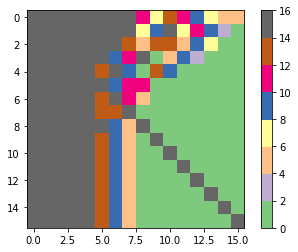

In [35]:
plot_box_ranks(mat1,nboxes,n)